# Face Mask Detection
Welcome! This notebook will guide you on how to build the face mask detection program.

First, let's import the libraries that we are going to use

In [1]:
import numpy as np
import pickle
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from torchvision import transforms, models
from bs4 import BeautifulSoup
from glob import glob

%matplotlib inline

## 1. Data Cleaning & Preprocessing
The dataset we will be using originated from [Kaggle](https://www.kaggle.com/andrewmvd/face-mask-detection). You can download and save it directly to the `./data` directory; however, it requires you to be signed in. Refer to this [alternative link](https://drive.google.com/drive/folders/1uBNCtr45XHmpvQ3ei9--nOSnRXchEkgt?usp=sharing) to download from Google Drive instead. Unzip the file and you will get 2 different folders: `/annotations` and `/images`.

### 1.1. Extracting Images & Labels
First, let me explain what is inside `annotations` and `images` directories.

1. Annotations: You will see a bunch of .xml files inside annotations. They contain information like: file names, x and y positions, labels, etc. Here is an example of the content of an .xml file
```
<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>325</xmin>
            <ymin>90</ymin>
            <xmax>360</xmax>
            <ymax>141</ymax>
        </bndbox>
    </object>
</annotation>
```

2. Images: Contains our image files in .png format. If you look at the .xml file above, under the `<filename>` tag, the name of the file is already provided. Let's grab a random example<br>
<b>NOTE: Image can contain multiple faces </b>

<img src='./resources/maksssksksss63.png' alt='maksssksksss63.png' style="float:left">


In [2]:
annotations = glob('./data/annotations/*.xml')

names = []
bounding_boxes = []
img_paths = []
n_masks = []

for a in annotations:
    with open(a, 'rb') as f:
        content = f.read()

    soup = BeautifulSoup(content, 'xml')

    filename = soup.find('filename').text
    objects = soup.find_all('object')
    n = 0
    for o in objects:
        name = o.find('name').text
        xmin = int(o.find('xmin').text)
        xmax = int(o.find('xmax').text)
        ymin = int(o.find('ymin').text)
        ymax = int(o.find('ymax').text)

        names.append(name)
        bounding_boxes.append([xmin, ymin, xmax, ymax])

        n = n + 1

    img_paths.append(filename)
    n_masks.append(n)

Use `glob` library to grab all .xml files inside the `annotations` directory. `glob` works similarly to the `regex`. Create a glob object pointing to your `annotations` directory. In my case, the path is `./data/annotations/`, then use wildcard (*) followed by `'.xml'` to find all files that end with .xml
<br><br>
Next, read the xml files with open() built-in function from Python. We will also use `BeautifulSoup` library to extract info according to the corresponding tags. Here, we are only interested in these tags only:
- `<filename>`
- `<name>`
- `<xmin>`
- `<xmax>`
- `<ymin>`
- `<ymax>`
<br>

All tags above exist inside the `<object>` tag, <b>except for `<filename>`</b>. Use `find_all` method from `BeautifulSoup` to find all tags inside the `object` tag
```
<object>
     <name>without_mask</name>
     <pose>Unspecified</pose>
     <truncated>0</truncated>
     <occluded>0</occluded>
     <difficult>0</difficult>
     <bndbox>
         <xmin>79</xmin>
         <ymin>105</ymin>
         <xmax>109</xmax>
         <ymax>142</ymax>
     </bndbox>
 </object>
```

In [3]:
BASE = './data/images/'
faces = []
j = 0

for i in range(len(img_paths)):
    full_path = BASE + img_paths[i]
    img = cv2.imread(full_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    while(j < len(bounding_boxes)):
        for k in range(n_masks[i]):
            face = img[bounding_boxes[j][1]:bounding_boxes[j][3], bounding_boxes[j][0]:bounding_boxes[j][2]]
            faces.append(face)
        
            j += 1
            
        break

Next, we read in all images and extract any faces/masks according to the x-y positions we got from the previous step.

In [4]:
IMG_SIZE = 64
encoded_labels = []
unique_labels = []

for i in range(len(faces)):
    faces[i] = cv2.resize(faces[i], (IMG_SIZE, IMG_SIZE))
    
for l in names:
    if l not in unique_labels:
        unique_labels.append(l)
    if l == 'without_mask':
        encoded_labels.append(0)
    elif l == 'with_mask':
        encoded_labels.append(1)
    else:
        encoded_labels.append(2)

To uniform all images, we need to resize them to a certain width and height. You can change the value of `IMG_SIZE` if you want to experiment with different values.

In [5]:
print("Total number of unique labels:", len(unique_labels))
print("Labels:", unique_labels)

Total number of unique labels: 3
Labels: ['without_mask', 'with_mask', 'mask_weared_incorrect']


In the end, we end up with 3 labels (without_mask, with_mask, and mask_weared_incorrect)

In [6]:
print("Total number of images:", len(faces))
print("'with_mask' labeled images:", sum(n == 'with_mask' for n in names))
print("'without_mask' labeled images:", sum(n == 'without_mask' for n in names))
print("'mask_weared_incorrect' labeled images:", sum(n == 'mask_weared_incorrect' for n in names))

Total number of images: 4072
'with_mask' labeled images: 3232
'without_mask' labeled images: 717
'mask_weared_incorrect' labeled images: 123


To check our work, we can display the extracted faces again along with its label

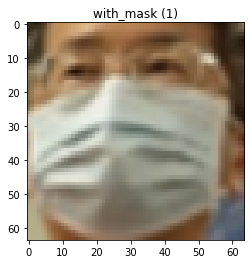

In [7]:
idx = 20

plt.imshow(faces[idx])
plt.title(names[idx] + ' (' + str(encoded_labels[idx]) + ')')
plt.show()

In [8]:
# save preprocessed data into a small pickle file to save time
data_pickle = {'features': faces, 'labels': encoded_labels}

with open('face_mask_dataset.pickle', 'wb') as f:
    pickle.dump(data_pickle, f)

Since the "Data Cleaning & Preprocessing" step is a little bit time consuming, we can always save the extracted faces and the encoded labels into a `pickle` file. If we want to reload the data, we can always read in the `pickle` file without repeating the steps above.

## Checkpoint 1 - Load Dataset

Next time we open this notebook again, we can just directly load the pickled data we did in the previous step

In [9]:
# load the saved pickle file
with open('face_mask_dataset.pickle', 'rb') as f:
    loaded_data = pickle.load(f)

features = loaded_data['features']
labels = loaded_data['labels']

## 2. Converting Data to Tensor

In order to train with our data, we have to convert both features and labels into a new data type called `Tensor`. In this step, we will also resize all images and split them into training and test data.

In [10]:
IMG_SIZE = 64
split_val = 0.8

features = np.asarray(features)
features = np.reshape(features, [len(features), 3, IMG_SIZE, IMG_SIZE])
labels = np.asarray(labels)
n_train = int(split_val * len(features))

train_features = features[:n_train]
train_labels = labels[:n_train]
test_features = features[n_train:]
test_labels = labels[n_train:]

train_data = torch.utils.data.TensorDataset(torch.from_numpy(train_features), torch.from_numpy(train_labels))
test_data = torch.utils.data.TensorDataset(torch.from_numpy(test_features), torch.from_numpy(test_labels))

BATCH_SIZE = 32
NUM_WORKERS = 0
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

Let's inspect inside one batch of our `train_loader`

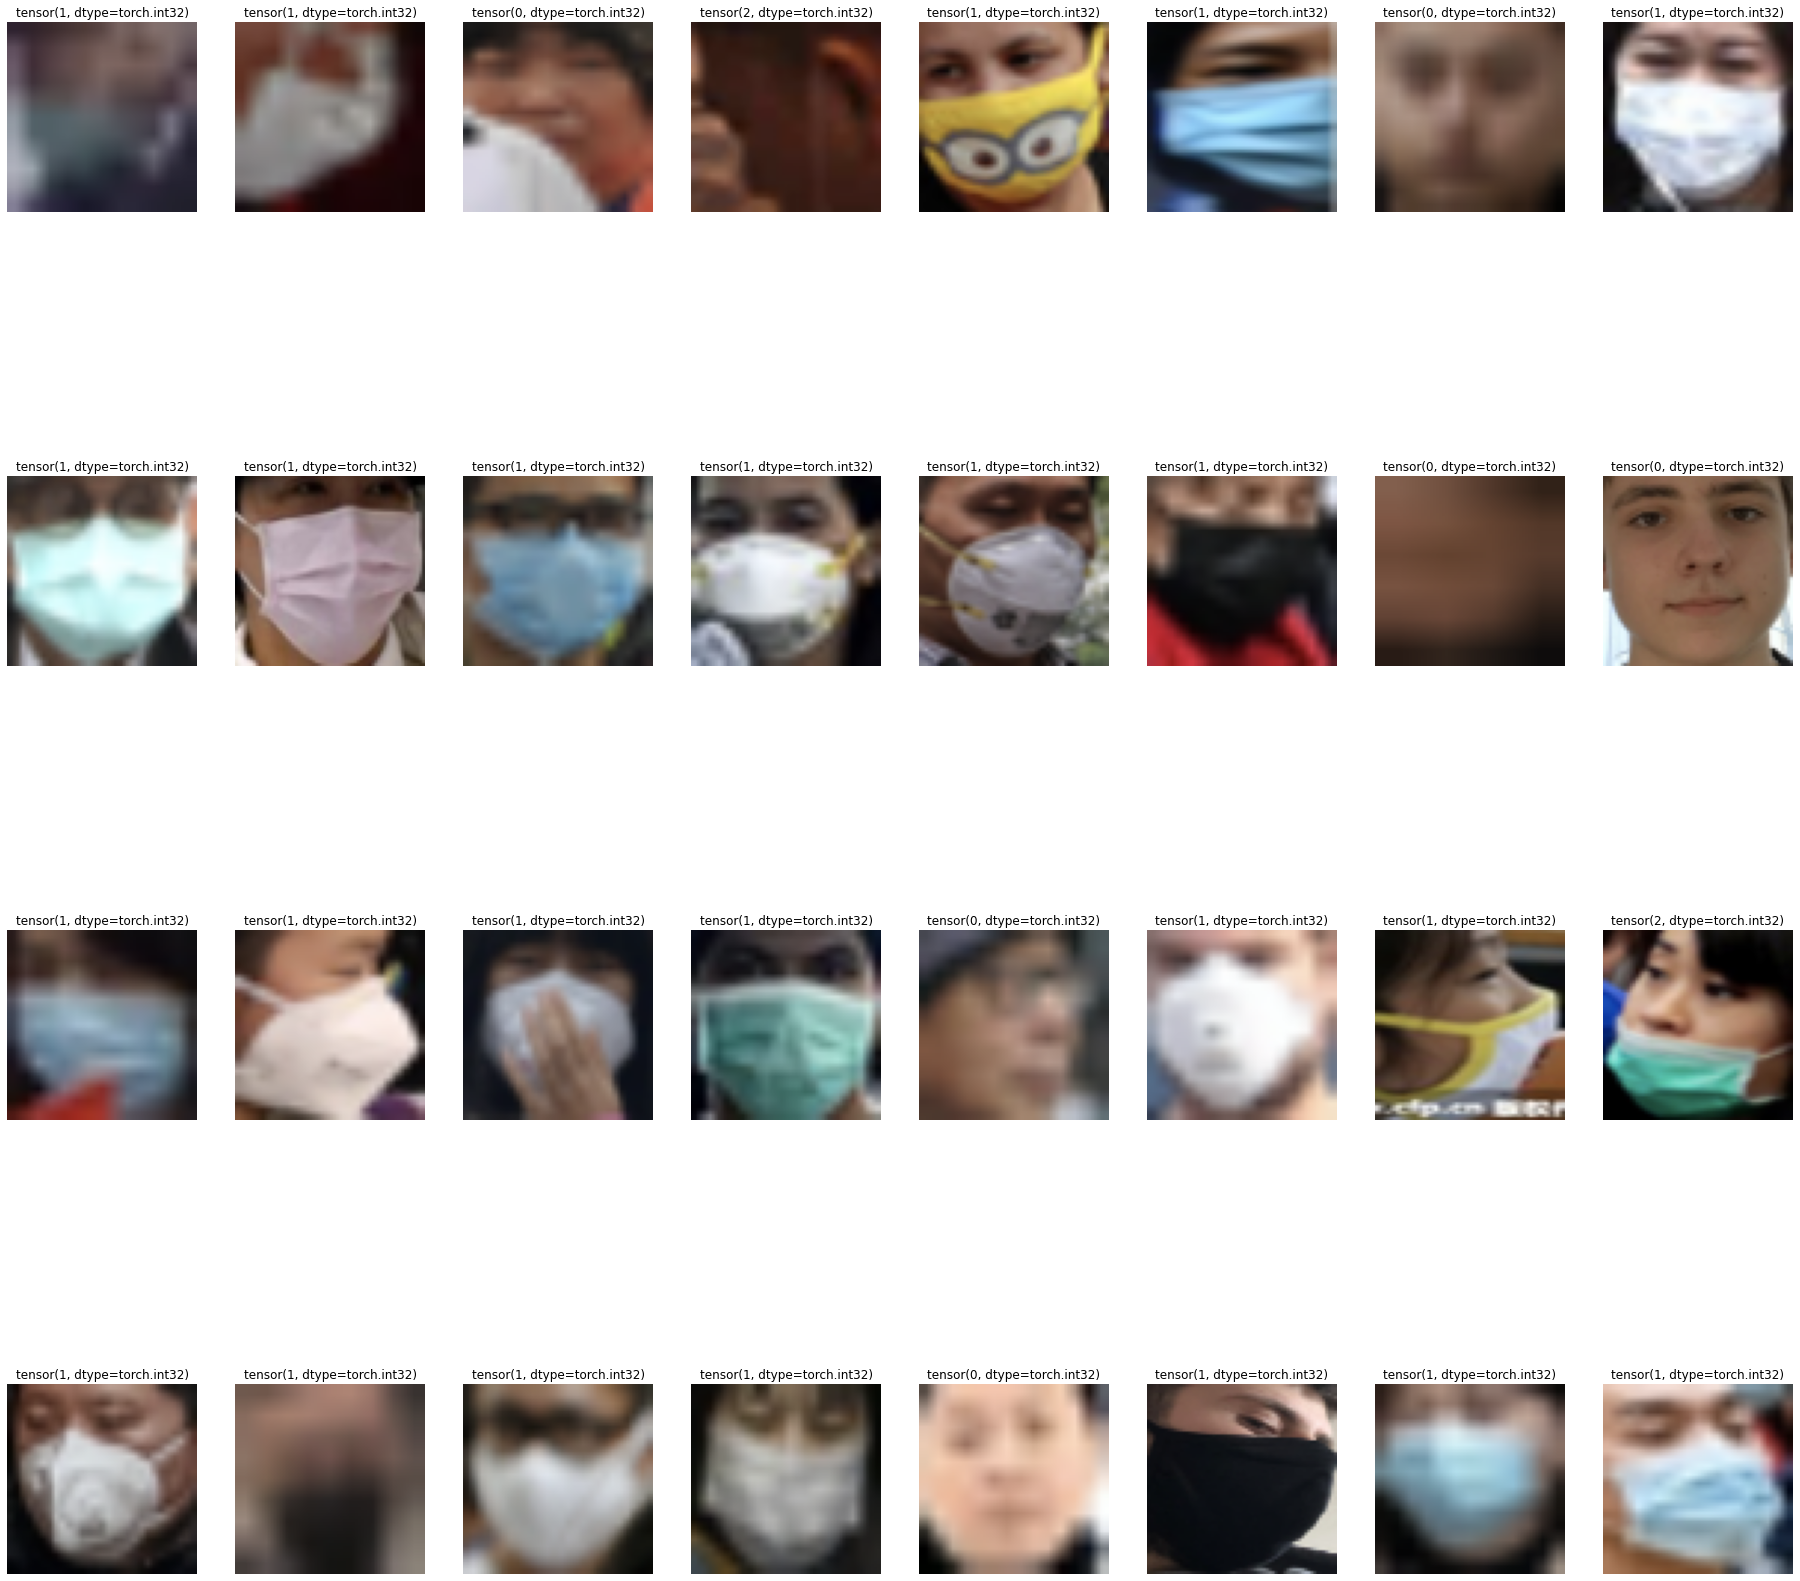

In [23]:
train_batch_x, train_batch_y = iter(train_loader).next()
train_batch_x = train_batch_x.view(BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3)
fig, ax = plt.subplots(4, 8, figsize=(32,32))

for (x, y, axi) in zip(train_batch_x, train_batch_y, ax.flatten()):
    axi.imshow(x)
    axi.set_title(str(y))
    axi.axis('off')
#     break

## 3. Building the Model

The model I used in this project consists of 3 convolutional layers, maxpool layers between them, and a single 128 dense layer. Feel free to experiment with the number of neurons, hidden layers, padding, etc.

In [13]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, (3,3), padding=1)
        self.conv2 = nn.Conv2d(16, 32, (3,3), padding=1)
        self.conv3 = nn.Conv2d(32, 64, (3,3), padding=1)
        self.pool = nn.MaxPool2d((2,2), 2)
        
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

## 4. Training the Model

Next, specify the `criterion` and `optimizer`. The code cell below will also check for CUDA to train our model with GPU. Don't worry if you don't have it, it still can train with CPU

In [15]:
use_cuda = torch.cuda.is_available()

model = Model()
if use_cuda:
    print('Training using GPU:', torch.cuda.get_device_name(0))
    model = model.cuda()
else:
    print('Training using CPU')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training using CPU


Now, let's train our model! The `train()` method below will return 2 values: the trained model itself and training loss history. If you want to omit the training loss history, you can just return the trained model without the training loss with the syntax below:
```
trained_model, _ = train(...)
```
We can save the model by giving the `save_path` parameter the name of our trained model

In [16]:
def train(num_epochs, model, loader, crit, opt, use_cuda, plot_curve=True, save_path=''):
    
    training_losses = []
    
    for i in range(num_epochs):
        training_loss = 0.0
        
        model.train()
        for batch, (feature, label) in enumerate(loader):
            feature = feature.to(torch.float)
            label = label.to(torch.long)
            if use_cuda:
                feature, label = feature.cuda(), label.cuda()
            
            opt.zero_grad()
            
            output = model(feature)
            loss = crit(output, label)
            loss.backward()
            opt.step()
            
            training_loss = training_loss + (1 / (batch + 1)) * (loss.data - training_loss)
            
        print("Epoch #{} | Training loss: {}".format(i+1, training_loss))
        training_losses.append(training_loss)
    
    if len(save_path) > 0:
        print('Saving model...')
        torch.save(model.state_dict(), save_path)
        print('Model saved:', save_path)
        
    if plot_curve:
        plt.plot(range(num_epochs), training_losses)
        plt.title('Training Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
    return model, training_losses

Epoch #1 | Training loss: 1.0492370128631592
Epoch #2 | Training loss: 0.3836541771888733
Epoch #3 | Training loss: 0.3082549571990967
Epoch #4 | Training loss: 0.25131547451019287
Epoch #5 | Training loss: 0.22274520993232727
Epoch #6 | Training loss: 0.2351994812488556
Epoch #7 | Training loss: 0.21648235619068146
Epoch #8 | Training loss: 0.19053757190704346
Epoch #9 | Training loss: 0.1773325353860855
Epoch #10 | Training loss: 0.15703193843364716
Epoch #11 | Training loss: 0.1379564255475998
Epoch #12 | Training loss: 0.13687153160572052
Epoch #13 | Training loss: 0.12912267446517944
Epoch #14 | Training loss: 0.09111350029706955
Epoch #15 | Training loss: 0.10172788798809052
Saving model...
Model saved: new_model.pt


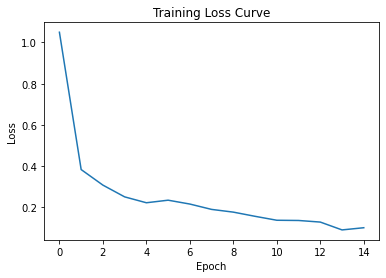

In [17]:
NUM_EPOCHS=15
final_model, training_losses = train(NUM_EPOCHS, model, train_loader, criterion, optimizer, use_cuda, save_path='')

Now, let's evaluate our model on the test data

In [18]:
def evaluate(model, loader, crit, use_cuda):
    
    all_preds = []
    ground_truths = []
    test_loss = 0.0
    num_correct = 0
    total_data = 0

    model.eval()
    for batch, (feature, label) in enumerate(loader):
        feature = feature.to(torch.float)
        label = label.to(torch.long)
        if use_cuda:
            feature, label = feature.cuda(), label.cuda()
        
        output = model(feature)
        loss = crit(output, label)
        
        test_loss = test_loss + (1/(batch+1)) * (loss.data - test_loss)
        total_data = total_data + feature.size(0)
        
        preds = output.data.max(1)[1]
        num_correct += np.sum(np.squeeze(preds.eq(label.data.view_as(preds))).cpu().numpy())
        
        all_preds.append(preds.cpu().detach().numpy().tolist())
        ground_truths.append(label.cpu().detach().numpy().tolist())
        
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {:.2f}%'.format(num_correct / total_data * 100))
    
    pred_temp = []
    label_temp = []
    
    for pred in all_preds:
        for p in pred:
            pred_temp.append(p)
    for labels in ground_truths:
        for l in labels:
            label_temp.append(l)
    
    print('\nConfusion Matrix')
    print(confusion_matrix(pred_temp, label_temp))
    print('\nClassification Report')
    print(classification_report(pred_temp, label_temp))
#     print('Recall Score:', recall_score(pred_temp, label_temp))
#     print('F1 Score:', f1_score(pred_temp, label_temp))
#     print(all_preds[0])
#     print(temp)
#     print(ground_truths)

Here, instead of pure accuracy, I also included confusion_matrix, precision, recall, and f1_score on the model evaluation. `precision` and `recall` give more insight on the model predictions rather than accuracy by itself. Using `scikit_learn`, we can directly call `classsification_report(predictions, actual_labels)` to display a classification report including precision, recall, and f1-score

In [19]:
evaluate(final_model, test_loader, criterion, use_cuda)

Test Loss: 0.3069321811199188
Test Accuracy: 91.41%

Confusion Matrix
[[ 94  18   3]
 [  9 641  12]
 [  6  22  10]]

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       115
           1       0.94      0.97      0.95       662
           2       0.40      0.26      0.32        38

    accuracy                           0.91       815
   macro avg       0.73      0.68      0.70       815
weighted avg       0.90      0.91      0.91       815



It seems like my model struggles on predicting label '2' (mask_weared_incorrect) while it has no problem predicting label '0' (without_mask) and '1' (with_mask) with high f1-score 

## Checkpoint 2 - Load Saved Model

To make predictions on new data, we don't need to retrain our model with the same hyperparameters. If you saved your model on the previous step, you can just load the saved model.

In [ ]:
MODEL_PATH = ''

use_cuda = torch.cuda.is_available()
model = Model()

if use_cuda:
    model = model.cuda()

model.load_state_dict(torch.load(MODEL_PATH))

In [ ]:
model

## 5. Making Predictions

Onto the final part, we can finally make some predictions on an image, video stream, or even streaming with webcam.

In [24]:
def predict(img_path, model, use_cuda):
    ## TO-DO: Predict incoming image input
    IMG_SIZE = 64
    labels = ['without_mask', 'with_mask', 'mask_weared_incorrect']
    prototxt_file = './data/deploy.prototxt.txt'
    caffemodel_file = './data/weights.caffemodel'
    
    img = cv2.imread(img_path)
    (h,w) = img.shape[:2]
    face_blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
    face_model = cv2.dnn.readNetFromCaffe(prototxt_file, caffemodel_file)
    face_model.setInput(face_blob)
    detector = face_model.forward()
    
    if len(detector) > 0:
        for i in range(0, detector.shape[2]):
            rect = detector[0,0,i,3:7] * np.array([w,h,w,h])
            (start_x, start_y, end_x, end_y) = rect.astype('int')
            
            confidence = detector[0,0,i,2]
            if confidence > 0.5:
                cv2.rectangle(img, (start_x, start_y), (end_x, end_y), (255,255,255), 2)
                
                face = img[start_y:end_y, start_x:end_x]
                resized_face = cv2.resize(face, (IMG_SIZE,IMG_SIZE))
                resized_face = np.expand_dims(resized_face, axis=0)
                resized_face = np.reshape(resized_face, [1,3,IMG_SIZE,IMG_SIZE])
                
                test_tensor = torch.Tensor(resized_face)
                
                model.eval()
                if use_cuda:
                    test_tensor = test_tensor.cuda()
                    
                output = model(test_tensor)
                pred = np.argmax(output.cpu().detach())
                print(pred)
                
                e_x = np.exp(output[0].cpu().detach().numpy())
                score = np.max(e_x / e_x.sum() * 100)
                text = '{}: {:.2f}%'.format(labels[pred], score)
                
                cv2.putText(img, text, (start_x, start_y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
                
    cv2.imshow('Prediction', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [25]:
predict('./data/images/maksssksksss26.png', model, use_cuda)

tensor(2)
tensor(0)


Use `cv2` to open a camera through your webcam. The code below will throw an error if your laptop/pc doesn't have one.

In [ ]:
def predict_from_webcam(model, use_cuda):
    
    IMG_SIZE = 64
    LABELS = ['without_mask', 'with_mask', 'mask_weared_incorrect']
    frame_name = 'Webcam Capture'
    prototxt_file = './data/deploy.prototxt.txt'
    caffemodel_file = './data/weights.caffemodel'
    
    cap = cv2.VideoCapture(0)
    face_model = cv2.dnn.readNetFromCaffe(prototxt_file, caffemodel_file)
    
    while True:
        ret, frame = cap.read()
        (h,w) = frame.shape[:2]
        face_blob = cv2.dnn.blobFromImage(frame, scalefactor=1.0, size=(300,300), mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
        face_model.setInput(face_blob)
        detector = face_model.forward()
        
        if len(detector) > 0:
            for i in range(0, detector.shape[2]):
                rect = detector[0,0,i,3:7] * np.array([w,h,w,h])
                (start_x, start_y, end_x, end_y) = rect.astype('int')
                confidence = detector[0,0,i,2]
                
                if confidence > 0.5:
                    face = frame[start_y:end_y, start_x:end_x]
                    if face.size == 0:
                        continue
                    
                    resized_face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
                    resized_face = np.expand_dims(resized_face, axis=0)
                    resized_face = np.reshape(resized_face, [1,3,IMG_SIZE,IMG_SIZE])
                    
                    test_feature = torch.Tensor(resized_face)
                    model.eval()
                    if use_cuda:
                        test_feature = test_feature.cuda()
                        
                    output = model(test_feature)
                    pred = np.argmax(output.cpu().detach())
                    
                    e_x = np.exp(output[0].cpu().detach().numpy())
                    score = np.max(e_x / e_x.sum() * 100)
                    text = '{}: {:.2f}%'.format(LABELS[pred], score)
#                     print(text)
                    if pred == 0:
                        cv2.putText(frame, text, (start_x, start_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,255), 2)
                        cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), (255,0,255), 2)
                    elif pred == 1:
                        cv2.putText(frame, text, (start_x, start_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,128,0), 2)
                        cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), (0,128,0), 2)
                    else:
                        cv2.putText(frame, text, (start_x, start_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0), 2)
                        cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), (255,255,0), 2)
                        
        cv2.imshow(frame_name, frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
predict_from_webcam(model, use_cuda)